<a href="https://colab.research.google.com/github/Arshia786-stack/LLM-Bias-Detection/blob/main/NLP_CLINICAL_BERT_%2B_DEATH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"
!pip install -q kaggle
!mkdir kaggle
!cp kaggle.json kaggle/
!ls kaggle
!chmod 600 kaggle/kaggle.json
!kaggle datasets list
!kaggle datasets download -d arshiamu/DataforBias

kaggle.json
ref                                                               title                                                   size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  ------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
atharvasoundankar/chocolate-sales                                 Chocolate Sales Data 📊🍫                                14473  2025-03-19 03:51:40.270000          14890        262  1.0              
adilshamim8/student-depression-dataset                            Student Depression Dataset                            467020  2025-03-13 03:12:30.423000           6462        102  1.0              
samayashar/billboard-top-songs                                    Billboard Top Songs 🎶                                 147043  2025-03-19 12:05:49.107000           1328         24  1.0   

In [ ]:
!unzip /content/DataforBias.zip

Archive:  /content/DataforBias.zip
  inflating: ADMISSIONS.csv          
  inflating: PATIENTS.csv            


In [ ]:
!pip install transformers fairlearn datasets scikit-learn pandas torch aif360 shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score
import shap

In [ ]:
! pip install sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 11.7 MB/s eta 0:00:00


## **LLM 1 : ClinicalBERT**

In [ ]:
model_name = "medicalai/ClinicalBERT"  # Pretrained ClinicalBERT
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Binary classification


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/542M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at medicalai/ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**PREPROCESSING OF DATA**

---



In [ ]:
def load_mimic_data():
    admissions_df = pd.read_csv("ADMISSIONS.csv")  # Clinical notes
    patients_df = pd.read_csv("PATIENTS.csv")  # Demographics (age, gender, ethnicity)

    # Merge datasets on SUBJECT_ID
    ehr_data = admissions_df.merge(patients_df, on="SUBJECT_ID")
    return ehr_data
ehr_data = load_mimic_data()
ehr_data.columns
ehr_data = ehr_data[['SUBJECT_ID' , 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'GENDER', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG']]
print(len(ehr_data))
ehr_data = ehr_data.dropna(subset=['SUBJECT_ID' , 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'GENDER', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG'])
print(len(ehr_data))


58976
48588


In [ ]:
ehr_data["TEXT_INPUT"] = (
    "Patient is " + ehr_data["GENDER"] +
    ", marital status: " + ehr_data["MARITAL_STATUS"] +
    ", ethnicity: " + ehr_data["ETHNICITY"] +
    ", religion: " + ehr_data["RELIGION"] +
    ". Diagnosis: " + ehr_data["DIAGNOSIS"]
)

# Now tokenize TEXT_INPUT instead of just DIAGNOSIS
tokenized_output = tokenizer(
    ehr_data["TEXT_INPUT"].tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

In [ ]:
ehr_data["TEXT_INPUT"]

,TEXT_INPUT
0,"Patient is F, marital status: MARRIED, ethnici..."
1,"Patient is M, marital status: MARRIED, ethnici..."
2,"Patient is M, marital status: MARRIED, ethnici..."
3,"Patient is M, marital status: SINGLE, ethnicit..."
4,"Patient is M, marital status: MARRIED, ethnici..."
...,...
58971,"Patient is F, marital status: SINGLE, ethnicit..."
58972,"Patient is F, marital status: WIDOWED, ethnici..."
58973,"Patient is M, marital status: MARRIED, ethnici..."
58974,"Patient is F, marital status: MARRIED, ethnici..."


**HUGGING FACE DATASET CREATION**

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments
import torch

# Assuming you're using BioGPT or ClinicalBERT
model_name = "medicalai/ClinicalBERT"  # Replace with the model you're using
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize the TEXT_INPUT column
def tokenize_function(examples):
    return tokenizer(examples['TEXT_INPUT'], padding='max_length', truncation=True, max_length=128)

# Convert dataframe to Hugging Face Dataset
dataset = Dataset.from_pandas(ehr_data)

# Apply tokenization
dataset = dataset.map(tokenize_function, batched=True)

# Rename 'HOSPITAL_EXPIRE_FLAG' to 'label' for training
dataset = dataset.rename_column("HOSPITAL_EXPIRE_FLAG", "label")  # Target variable

Map:   0%|          | 0/48588 [00:00<?, ? examples/s]

**TRAINING OF DATA**

In [ ]:
# Step 6: Train/Test Split
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Step 7: Fine-Tune the model
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01
)

# Define the Trainer with model, arguments, and datasets
trainer = Trainer(
    model=model,  # Load your pretrained model (BioGPT/ClinicalBERT)
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Start training
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shreyase (shreyase-usc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.331700,0.323928
2,0.324400,0.345556
3,0.303000,0.323994


TrainOutput(global_step=14577, training_loss=0.3239668449469372, metrics={'train_runtime': 2924.4477, 'train_samples_per_second': 39.874, 'train_steps_per_second': 4.985, 'total_flos': 3861755839319040.0, 'train_loss': 0.3239668449469372, 'epoch': 3.0})

SAVING THE MODEL

In [ ]:
# Create a directory to save the fine-tuned model
model_save_path = "./clincial_bert_model"
trainer.save_model(model_save_path)  # Saves model + tokenizer

# Save tokenizer separately (just to be safe)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved successfully at {model_save_path}")

Model saved successfully at ./clincial_bert_model


PREDICTIONS

In [ ]:
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    # Move inputs to the same device as the model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        logits = model(**inputs).logits
    return torch.argmax(logits, dim=1).item()

# Apply predictions to your data
ehr_data['predictions'] = ehr_data['TEXT_INPUT'].apply(lambda x: predict(x))

# **ETHNICITY**

In [ ]:
y_true = ehr_data['HOSPITAL_EXPIRE_FLAG'].values  # Actual hospital outcome
y_pred = ehr_data['predictions'].values  # Predicted outcomes
groups = ehr_data['ETHNICITY'].values  # Sensitive feature (e.g., ETHNICITY or GENDER)

FAIRNESS METRICS

In [ ]:
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

dem_parity = demographic_parity_difference(y_true=y_true, y_pred=y_pred, sensitive_features=groups) # Added keyword argument sensitive_features
eq_odds = equalized_odds_difference(y_true=y_true, y_pred=y_pred, sensitive_features=groups)

print(f"Demographic Parity Difference: {dem_parity:.4f}")
print(f"Equalized Odds Difference: {eq_odds:.4f}")

Demographic Parity Difference: 0.1667
Equalized Odds Difference: 0.5000


In [ ]:
import pandas as pd

# Create a DataFrame to analyze group-level disparities
fairness_df = ehr_data.groupby("ETHNICITY").agg(
    total_samples=("ETHNICITY", "count"),
    positive_actual=("HOSPITAL_EXPIRE_FLAG", "sum"),  # Actual death cases
    positive_predicted=("predictions", "sum")  # Predicted death cases
)
# Compute positive rates (probability of being classified as "1")
fairness_df["actual_positive_rate"] = fairness_df["positive_actual"] / fairness_df["total_samples"]
fairness_df["predicted_positive_rate"] = fairness_df["positive_predicted"] / fairness_df["total_samples"]
# Show results
print(fairness_df.to_string())

                                                          total_samples  positive_actual  positive_predicted  actual_positive_rate  predicted_positive_rate
ETHNICITY                                                                                                                                                  
AMERICAN INDIAN/ALASKA NATIVE                                        22                2                   0              0.090909                 0.000000
AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE              3                1                   0              0.333333                 0.000000
ASIAN                                                               774               91                  10              0.117571                 0.012920
ASIAN - ASIAN INDIAN                                                 81                3                   0              0.037037                 0.000000
ASIAN - CAMBODIAN                                               

In [ ]:
from sklearn.metrics import confusion_matrix

# Store results per ethnicity
ethnicity_analysis = []

for ethnicity in ehr_data["ETHNICITY"].unique():
    subset = ehr_data[ehr_data["ETHNICITY"] == ethnicity]

    # Compute confusion matrix
    cm = confusion_matrix(subset["HOSPITAL_EXPIRE_FLAG"], subset["predictions"])

    # Check the shape of the confusion matrix
    if cm.shape == (2, 2):  # Check for a 2x2 matrix (binary classification)
        tn, fp, fn, tp = cm.ravel()
    elif cm.shape == (1, 1):  # Check for a 1x1 matrix (only one class present)
        # Handle this case (e.g., set values to 0 or print a warning)
        tn, fp, fn, tp = cm[0][0], 0, 0, 0  # Assuming one class was predicted
    else:
        # Handle other cases or print an error
        print(f"Unexpected confusion matrix shape for {ethnicity}: {cm.shape}")
        continue

    # Compute rates
    # Handle potential ZeroDivisionError when denominator is 0
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) != 0 else 0

    ethnicity_analysis.append({
        "Ethnicity": ethnicity,
        "False Positive Rate": fpr,
        "False Negative Rate": fnr
    })

# Convert to DataFrame
ethnicity_bias_df = pd.DataFrame(ethnicity_analysis)

# Display results
print(ethnicity_bias_df.to_string())

                                                   Ethnicity  False Positive Rate  False Negative Rate
0                                                      WHITE             0.004660             0.948420
1                                      UNKNOWN/NOT SPECIFIED             0.038328             0.684008
2                                       MULTI RACE ETHNICITY             0.000000             0.888889
3                                         HISPANIC OR LATINO             0.002465             0.949495
4                                 PATIENT DECLINED TO ANSWER             0.007500             0.975000
5                                     BLACK/AFRICAN AMERICAN             0.004294             0.936340
6                                                      ASIAN             0.007321             0.945055
7                               HISPANIC/LATINO - GUATEMALAN             0.000000             1.000000
8                                                      OTHER             

In [ ]:
ehr_data.to_csv('ehr_data.csv')
fairness_df.to_csv('fairness_df_cb.csv')
ethnicity_bias_df.to_csv('ethnicity_bias_df_cb.csv')

ehr_data_predicted_cb = pd.read_csv('ehr_data.csv')
fairness_df_cb= pd.read_csv('fairness_df_cb.csv')
ethnicity_bias_df_cb = pd.read_csv('ethnicity_bias_df_cb.csv')

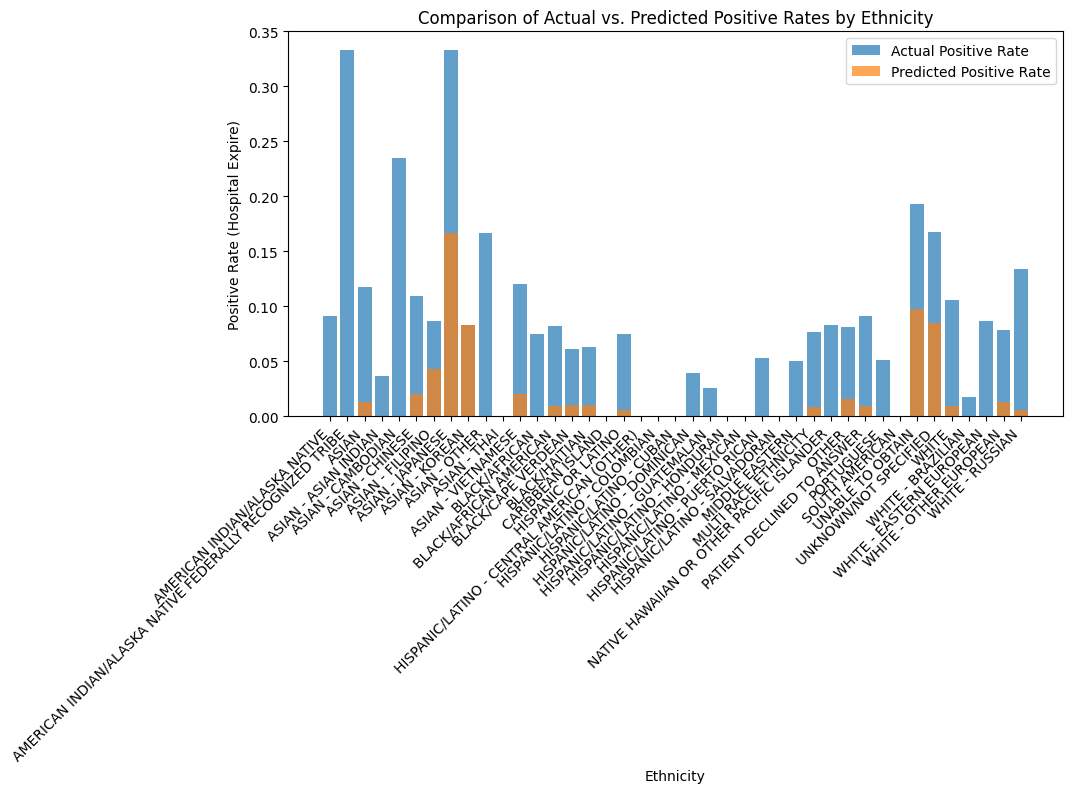

In [ ]:
import matplotlib.pyplot as plt

# Sort by actual positive rate for better visualization
fairness_df = fairness_df.sort_values(by="actual_positive_rate", ascending=False)

# Plot
plt.figure(figsize=(10, 5))
plt.bar(fairness_df_cb["ETHNICITY"], fairness_df_cb["actual_positive_rate"], label="Actual Positive Rate", alpha=0.7)
plt.bar(fairness_df_cb["ETHNICITY"], fairness_df_cb["predicted_positive_rate"], label="Predicted Positive Rate", alpha=0.7)
plt.xlabel("Ethnicity")
plt.ylabel("Positive Rate (Hospital Expire)")
plt.title("Comparison of Actual vs. Predicted Positive Rates by Ethnicity")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.show()

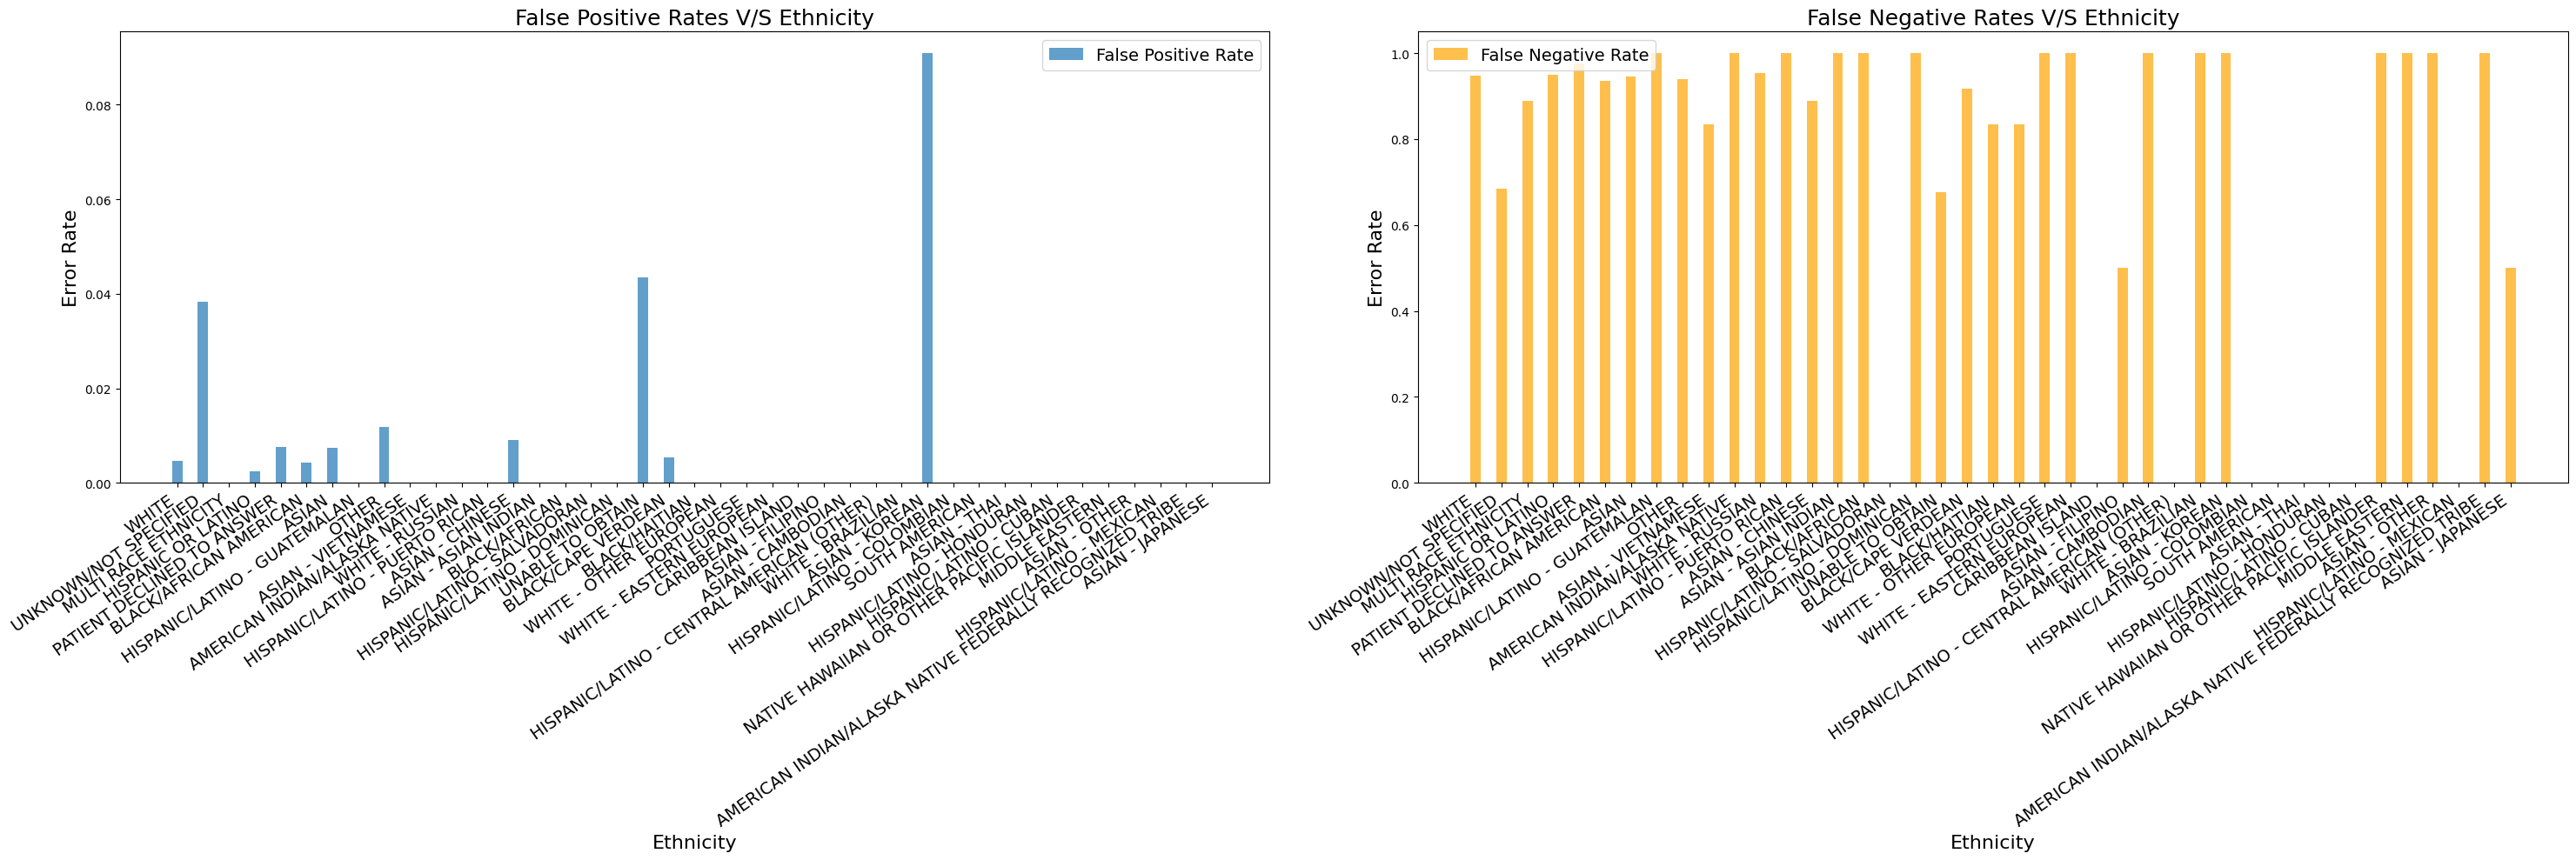

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10))  # Increased width and height

# False Positive Rate plot
axes[0].bar(ethnicity_bias_df["Ethnicity"], ethnicity_bias_df["False Positive Rate"], label="False Positive Rate", alpha=0.7, width=0.4)
axes[0].set_xlabel("Ethnicity", fontsize=16)
axes[0].set_ylabel("Error Rate", fontsize=16)
axes[0].set_title("False Positive Rates V/S Ethnicity", fontsize=18)
axes[0].legend(fontsize=14)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].set_xticklabels(ethnicity_bias_df["Ethnicity"], rotation=35, ha="right")  # Increased rotation

# False Negative Rate plot
axes[1].bar(ethnicity_bias_df["Ethnicity"], ethnicity_bias_df["False Negative Rate"], label="False Negative Rate", alpha=0.7, color='orange', width=0.4)
axes[1].set_xlabel("Ethnicity", fontsize=16)
axes[1].set_ylabel("Error Rate", fontsize=16)
axes[1].set_title("False Negative Rates V/S Ethnicity", fontsize=18)
axes[1].legend(fontsize=14)
axes[1].tick_params(axis='x', labelsize=14)
axes[1].set_xticklabels(ethnicity_bias_df["Ethnicity"], rotation=35, ha="right")  # Increased rotation

# Adjust spacing
plt.subplots_adjust(wspace=0.5, bottom=0.35)  # Increased space between subplots and bottom margin
plt.tight_layout()
plt.show()

# **GENDER**

In [ ]:
y_true = ehr_data['HOSPITAL_EXPIRE_FLAG'].values  # Actual hospital outcome
y_pred = ehr_data['predictions'].values  # Predicted outcomes
groups = ehr_data['GENDER'].values  # Sensitive feature (e.g., ETHNICITY or GENDER)

In [ ]:
dem_parity = demographic_parity_difference(y_true=y_true, y_pred=y_pred, sensitive_features=groups) # Added keyword argument sensitive_features
eq_odds = equalized_odds_difference(y_true=y_true, y_pred=y_pred, sensitive_features=groups)

print(f"Demographic Parity Difference: {dem_parity:.4f}")
print(f"Equalized Odds Difference: {eq_odds:.4f}")

Demographic Parity Difference: 0.0004
Equalized Odds Difference: 0.0087


In [ ]:
gender_fairness_df_cb = ehr_data.groupby("GENDER").agg(
    total_samples=("GENDER", "count"),
    positive_actual=("HOSPITAL_EXPIRE_FLAG", "sum"),  # Actual death cases
    positive_predicted=("predictions", "sum")          # Predicted death cases
)

# Compute positive rates (probability of being classified as "1")
gender_fairness_df_cb["actual_positive_rate"] = gender_fairness_df_cb["positive_actual"] / gender_fairness_df_cb["total_samples"]
gender_fairness_df_cb["predicted_positive_rate"] = gender_fairness_df_cb["positive_predicted"] / gender_fairness_df_cb["total_samples"]

# Show results
print(gender_fairness_df_cb.to_string())

        total_samples  positive_actual  positive_predicted  actual_positive_rate  predicted_positive_rate
GENDER                                                                                                   
F               21381             2390                 324              0.111781                 0.015154
M               27207             2760                 424              0.101444                 0.015584


In [ ]:
gender_analysis = []

for gender in ehr_data["GENDER"].unique():
    subset = ehr_data[ehr_data["GENDER"] == gender]

    # Compute confusion matrix for binary classification
    cm = confusion_matrix(subset["HOSPITAL_EXPIRE_FLAG"], subset["predictions"])

    # Check the shape of the confusion matrix
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    elif cm.shape == (1, 1):  # Only one class present
        tn, fp, fn, tp = cm[0][0], 0, 0, 0
    else:
        print(f"Unexpected confusion matrix shape for {gender}: {cm.shape}")
        continue

    # Compute False Positive Rate (FPR) and False Negative Rate (FNR)
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) != 0 else 0

    gender_analysis.append({
        "Gender": gender,
        "False Positive Rate": fpr,
        "False Negative Rate": fnr
    })

# Convert results into a DataFrame and display them
gender_bias_df_cb = pd.DataFrame(gender_analysis)
print(gender_bias_df_cb)

  Gender  False Positive Rate  False Negative Rate
0      F             0.006898             0.919247
1      M             0.007240             0.910507


In [ ]:
gender_fairness_df_cb.to_csv('gender_fairness_df_cb.csv')
gender_bias_df_cb.to_csv('gender_bias_df_cb.csv')

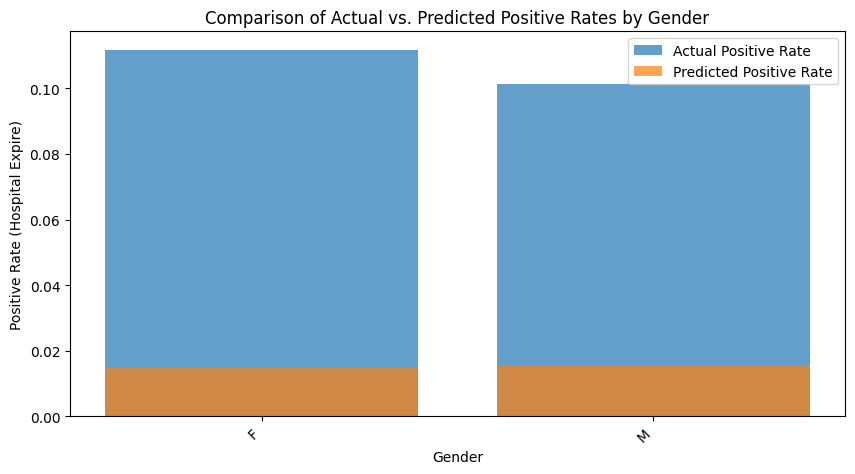

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(gender_fairness_df_cb.index, gender_fairness_df_cb["actual_positive_rate"], label="Actual Positive Rate", alpha=0.7)
plt.bar(gender_fairness_df_cb.index, gender_fairness_df_cb["predicted_positive_rate"], label="Predicted Positive Rate", alpha=0.7)
plt.xlabel("Gender")
plt.ylabel("Positive Rate (Hospital Expire)")
plt.title("Comparison of Actual vs. Predicted Positive Rates by Gender")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.show()

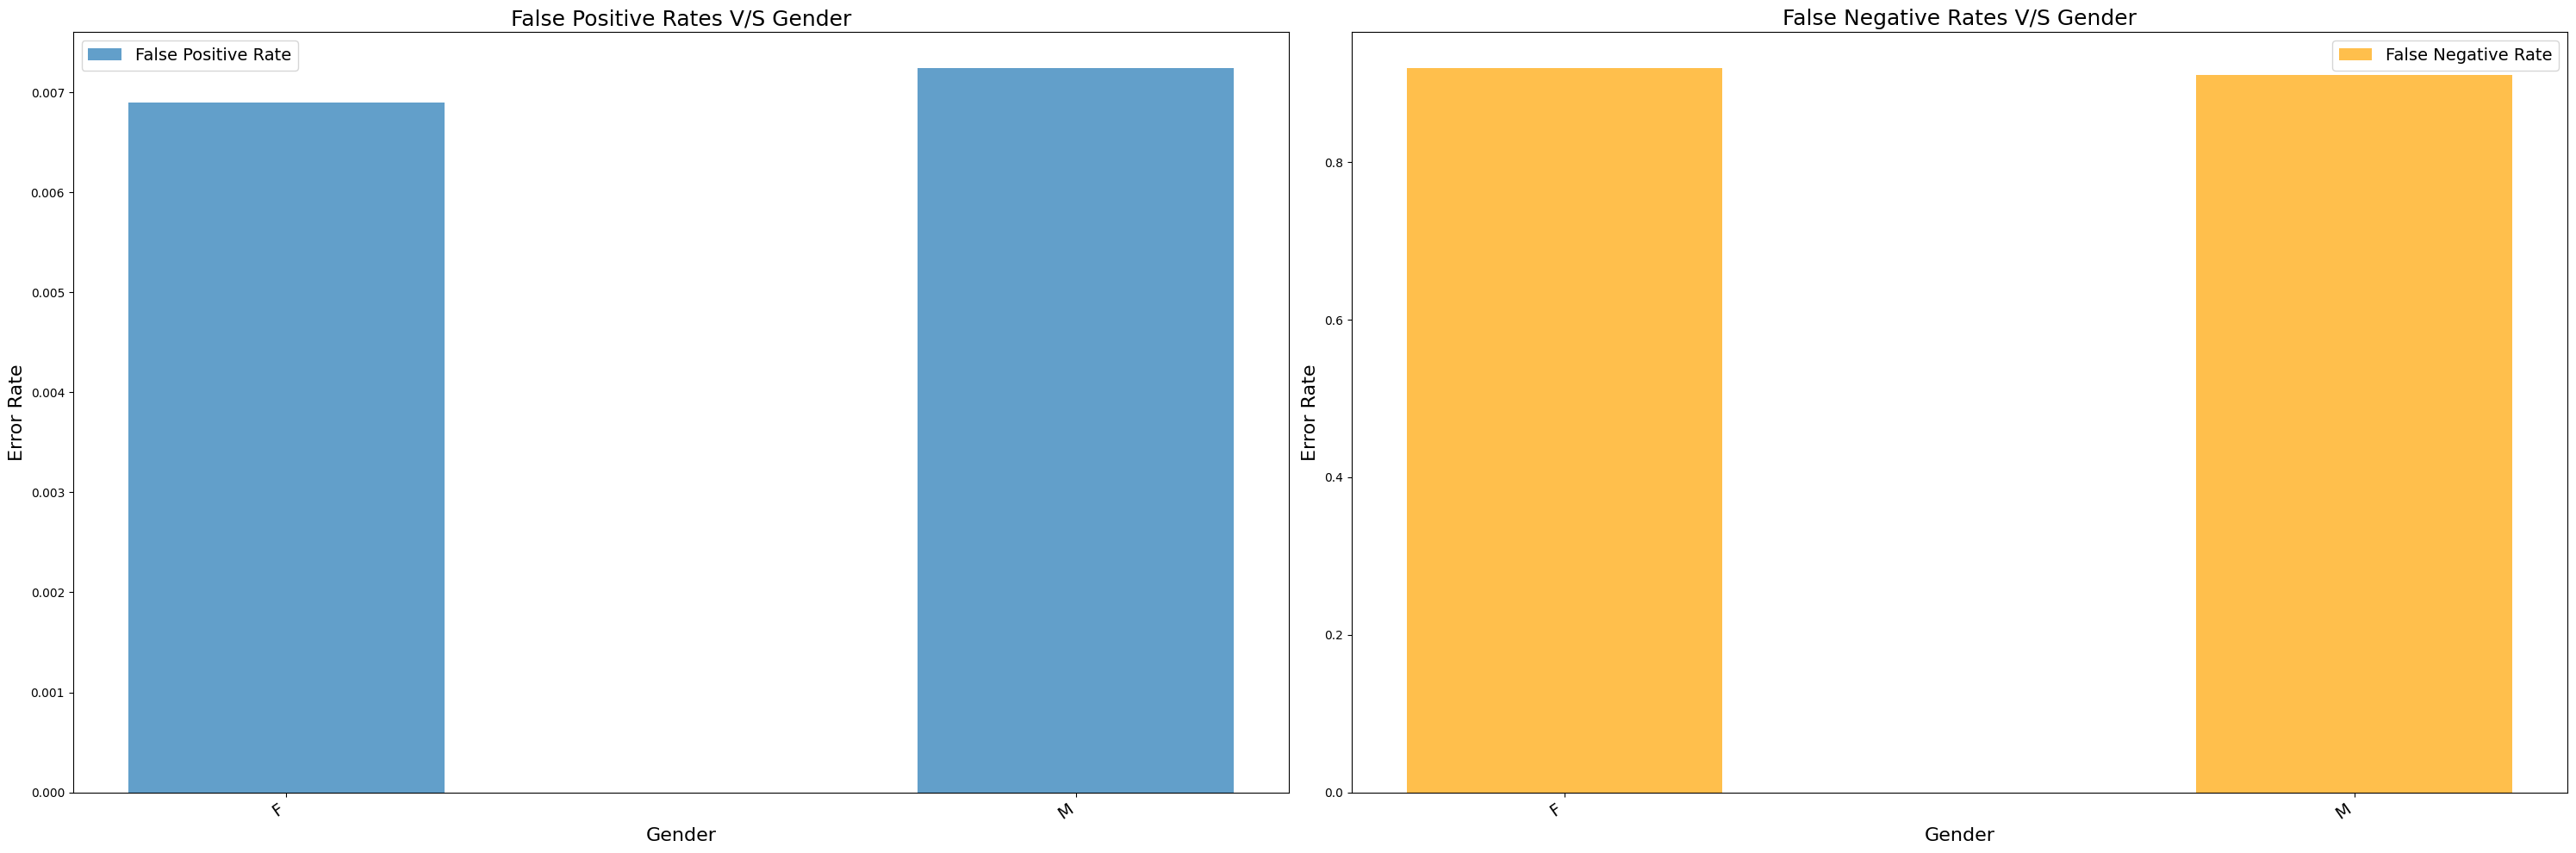

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10))  # Increased width and height

# False Positive Rate plot
axes[0].bar(gender_bias_df_cb["Gender"], gender_bias_df_cb["False Positive Rate"], label="False Positive Rate", alpha=0.7, width=0.4)
axes[0].set_xlabel("Gender", fontsize=16)
axes[0].set_ylabel("Error Rate", fontsize=16)
axes[0].set_title("False Positive Rates V/S Gender", fontsize=18)
axes[0].legend(fontsize=14)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].set_xticklabels(gender_bias_df_cb["Gender"], rotation=35, ha="right")  # Increased rotation

# False Negative Rate plot
axes[1].bar(gender_bias_df_cb["Gender"], gender_bias_df_cb["False Negative Rate"], label="False Negative Rate", alpha=0.7, color='orange', width=0.4)
axes[1].set_xlabel("Gender", fontsize=16)
axes[1].set_ylabel("Error Rate", fontsize=16)
axes[1].set_title("False Negative Rates V/S Gender", fontsize=18)
axes[1].legend(fontsize=14)
axes[1].tick_params(axis='x', labelsize=14)
axes[1].set_xticklabels(gender_bias_df_cb["Gender"], rotation=35, ha="right")  # Increased rotation

# Adjust spacing
plt.subplots_adjust(wspace=0.5, bottom=0.35)  # Increased space between subplots and bottom margin
plt.tight_layout()
plt.show()

# **RELIGION**

In [ ]:
religion_fairness_df_cb = ehr_data.groupby("RELIGION").agg(
    total_samples=("RELIGION", "count"),
    positive_actual=("HOSPITAL_EXPIRE_FLAG", "sum"),  # Actual death cases
    positive_predicted=("predictions", "sum")           # Predicted death cases
)

# Compute positive rates (probability of being classified as "1")
religion_fairness_df_cb["actual_positive_rate"] = religion_fairness_df_cb["positive_actual"] / religion_fairness_df_cb["total_samples"]
religion_fairness_df_cb["predicted_positive_rate"] = religion_fairness_df_cb["positive_predicted"] / religion_fairness_df_cb["total_samples"]

# Display the fairness results
print(religion_fairness_df_cb.to_string())

                        total_samples  positive_actual  positive_predicted  actual_positive_rate  predicted_positive_rate
RELIGION                                                                                                                 
7TH DAY ADVENTIST                  73                5                   1              0.068493                 0.013699
BAPTIST                            28                8                   1              0.285714                 0.035714
BUDDHIST                          217               19                   3              0.087558                 0.013825
CATHOLIC                        18267             1854                 221              0.101494                 0.012098
CHRISTIAN SCIENTIST               337               29                   4              0.086053                 0.011869
EPISCOPALIAN                      693               63                   7              0.090909                 0.010101
GREEK ORTHODOX          

In [ ]:
religion_analysis = []

for religion in ehr_data["RELIGION"].unique():
    subset = ehr_data[ehr_data["RELIGION"] == religion]

    # Compute confusion matrix for binary classification
    cm = confusion_matrix(subset["HOSPITAL_EXPIRE_FLAG"], subset["predictions"])

    # Check the shape of the confusion matrix
    if cm.shape == (2, 2):  # Normal binary case
        tn, fp, fn, tp = cm.ravel()
    elif cm.shape == (1, 1):  # Only one class present
        tn, fp, fn, tp = cm[0][0], 0, 0, 0
    else:
        print(f"Unexpected confusion matrix shape for {religion}: {cm.shape}")
        continue

    # Compute False Positive Rate (FPR) and False Negative Rate (FNR)
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) != 0 else 0

    religion_analysis.append({
        "Religion": religion,
        "False Positive Rate": fpr,
        "False Negative Rate": fnr
    })

# Convert the analysis to a DataFrame and display the results
religion_bias_df_cb = pd.DataFrame(religion_analysis)
print(religion_bias_df_cb)

                  Religion  False Positive Rate  False Negative Rate
0             UNOBTAINABLE             0.022303             0.807692
1                 CATHOLIC             0.006519             0.938511
2        PROTESTANT QUAKER             0.006304             0.910377
3            NOT SPECIFIED             0.004124             0.925030
4                   JEWISH             0.006959             0.948718
5                 BUDDHIST             0.010101             0.947368
6        JEHOVAH'S WITNESS             0.009009             0.937500
7                    OTHER             0.001438             0.923497
8           GREEK ORTHODOX             0.007895             0.973684
9             EPISCOPALIAN             0.004762             0.936508
10     CHRISTIAN SCIENTIST             0.009740             0.965517
11                  HEBREW             0.000000             1.000000
12               METHODIST             0.000000             1.000000
13  UNITARIAN-UNIVERSALIST        

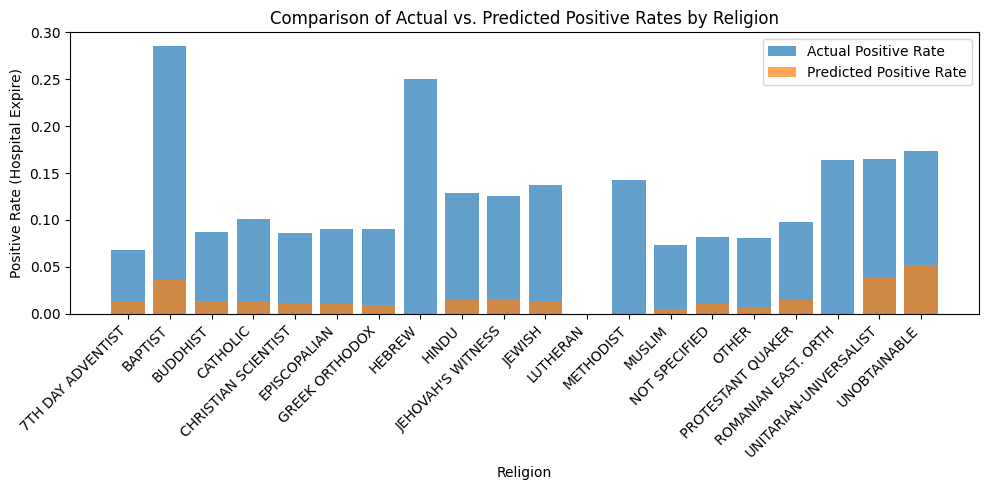

In [ ]:
plt.figure(figsize=(10, 5))
# Using the index (i.e. the religion names) for the x-axis labels
plt.bar(religion_fairness_df_cb.index, religion_fairness_df_cb["actual_positive_rate"],label="Actual Positive Rate", alpha=0.7)
plt.bar(religion_fairness_df_cb.index, religion_fairness_df_cb["predicted_positive_rate"],label="Predicted Positive Rate", alpha=0.7)
plt.xlabel("Religion")
plt.ylabel("Positive Rate (Hospital Expire)")
plt.title("Comparison of Actual vs. Predicted Positive Rates by Religion")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

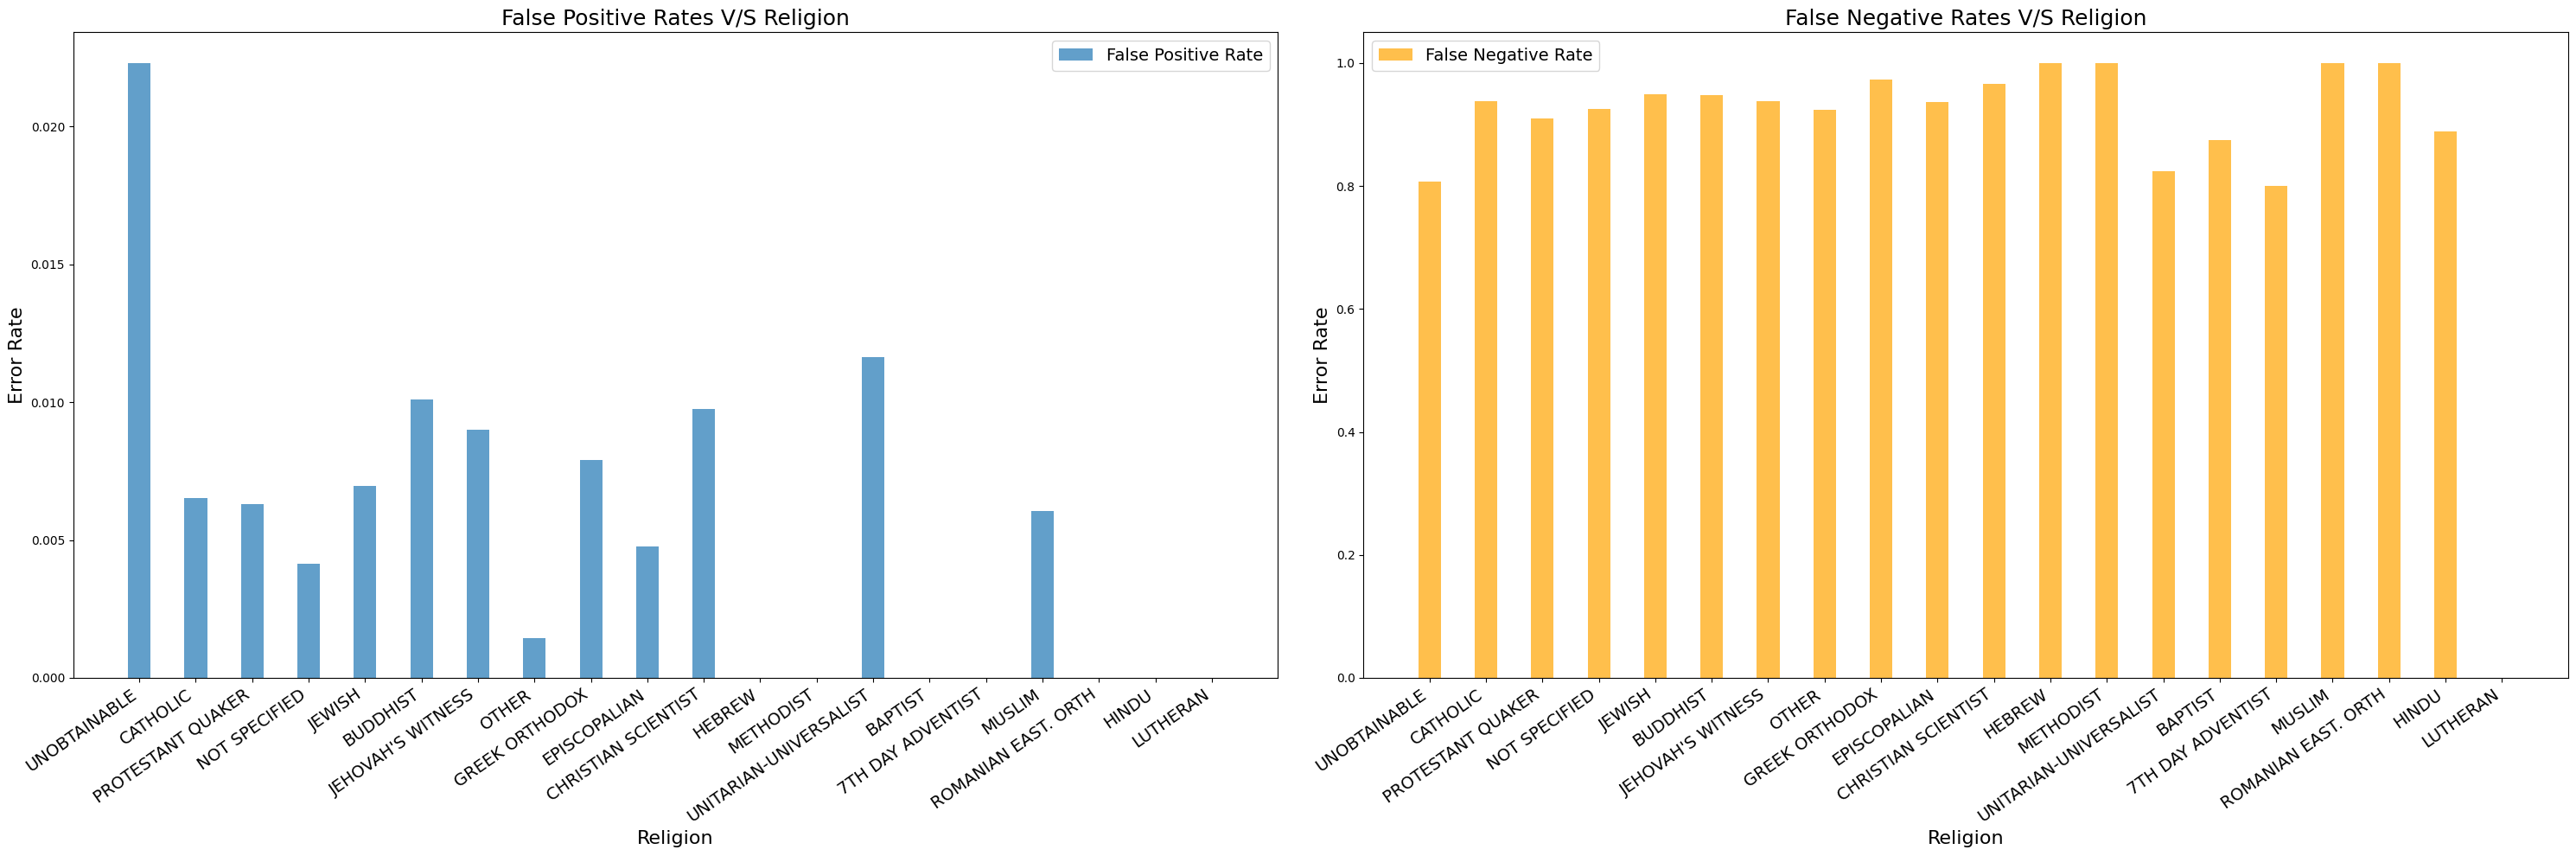

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10))  # Increased width and height

# False Positive Rate plot
axes[0].bar(religion_bias_df_cb["Religion"], religion_bias_df_cb["False Positive Rate"], label="False Positive Rate", alpha=0.7, width=0.4)
axes[0].set_xlabel("Religion", fontsize=16)
axes[0].set_ylabel("Error Rate", fontsize=16)
axes[0].set_title("False Positive Rates V/S Religion", fontsize=18)
axes[0].legend(fontsize=14)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].set_xticklabels(religion_bias_df_cb["Religion"], rotation=35, ha="right")  # Increased rotation

# False Negative Rate plot
axes[1].bar(religion_bias_df_cb["Religion"], religion_bias_df_cb["False Negative Rate"], label="False Negative Rate", alpha=0.7, color='orange', width=0.4)
axes[1].set_xlabel("Religion", fontsize=16)
axes[1].set_ylabel("Error Rate", fontsize=16)
axes[1].set_title("False Negative Rates V/S Religion", fontsize=18)
axes[1].legend(fontsize=14)
axes[1].tick_params(axis='x', labelsize=14)
axes[1].set_xticklabels(religion_bias_df_cb["Religion"], rotation=35, ha="right")  # Increased rotation

# Adjust spacing
plt.subplots_adjust(wspace=0.5, bottom=0.35)  # Increased space between subplots and bottom margin
plt.tight_layout()
plt.show()

In [ ]:
marital_fairness_df_cb = ehr_data.groupby("MARITAL_STATUS").agg(
    total_samples=("MARITAL_STATUS", "count"),
    positive_actual=("HOSPITAL_EXPIRE_FLAG", "sum"),  # Actual death cases
    positive_predicted=("predictions", "sum")           # Predicted death cases
)

# Compute positive rates (probability of being classified as "1")
marital_fairness_df_cb["actual_positive_rate"] = marital_fairness_df_cb["positive_actual"] / marital_fairness_df_cb["total_samples"]
marital_fairness_df_cb["predicted_positive_rate"] = marital_fairness_df_cb["positive_predicted"] / marital_fairness_df_cb["total_samples"]

# Display the fairness results
print(marital_fairness_df_cb.to_string())

                   total_samples  positive_actual  positive_predicted  actual_positive_rate  predicted_positive_rate
MARITAL_STATUS                                                                                                      
DIVORCED                    3202              318                  50              0.099313                 0.015615
LIFE PARTNER                  15                0                   0              0.000000                 0.000000
MARRIED                    24073             2584                 447              0.107340                 0.018569
SEPARATED                    570               54                  12              0.094737                 0.021053
SINGLE                     13199             1084                 115              0.082127                 0.008713
UNKNOWN (DEFAULT)            344               65                  29              0.188953                 0.084302
WIDOWED                     7185             1045               

In [ ]:
marital_analysis = []

for status in ehr_data["MARITAL_STATUS"].unique():
    subset = ehr_data[ehr_data["MARITAL_STATUS"] == status]

    # Compute confusion matrix for binary classification
    cm = confusion_matrix(subset["HOSPITAL_EXPIRE_FLAG"], subset["predictions"])

    # Check the shape of the confusion matrix
    if cm.shape == (2, 2):  # Typical binary classification
        tn, fp, fn, tp = cm.ravel()
    elif cm.shape == (1, 1):  # Only one class is present
        tn, fp, fn, tp = cm[0][0], 0, 0, 0
    else:
        print(f"Unexpected confusion matrix shape for {status}: {cm.shape}")
        continue

    # Compute False Positive Rate (FPR) and False Negative Rate (FNR)
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) != 0 else 0

    marital_analysis.append({
        "Marital Status": status,
        "False Positive Rate": fpr,
        "False Negative Rate": fnr
    })

# Convert the analysis to a DataFrame and display the results
marital_bias_df_cb = pd.DataFrame(marital_analysis)
print(marital_bias_df_cb.to_string())

      Marital Status  False Positive Rate  False Negative Rate
0            MARRIED             0.009354             0.904799
1             SINGLE             0.003714             0.935424
2           DIVORCED             0.007282             0.908805
3            WIDOWED             0.004560             0.935885
4          SEPARATED             0.007752             0.851852
5  UNKNOWN (DEFAULT)             0.032258             0.692308
6       LIFE PARTNER             0.000000             0.000000


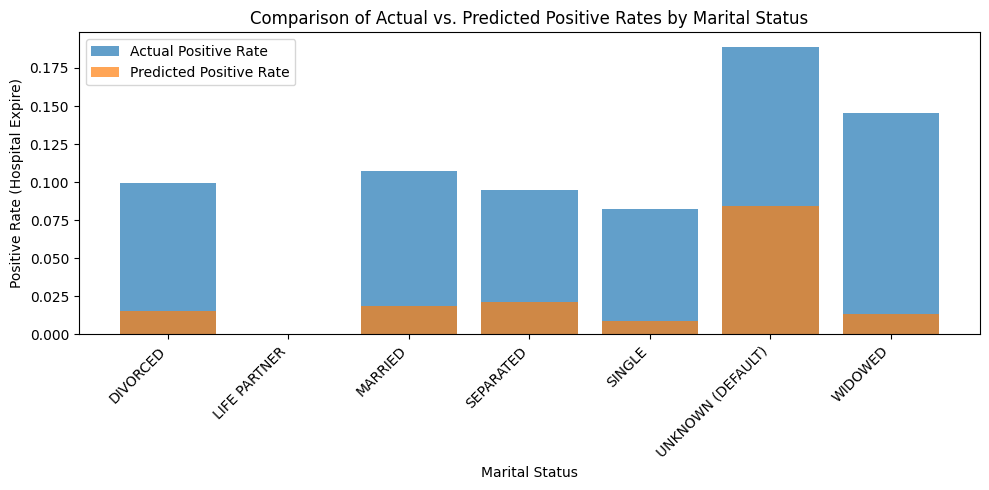

In [ ]:
plt.figure(figsize=(10, 5))
# Plotting using the index (MARITAL_STATUS) for the x-axis labels
plt.bar(marital_fairness_df_cb.index, marital_fairness_df_cb["actual_positive_rate"],
        label="Actual Positive Rate", alpha=0.7)
plt.bar(marital_fairness_df_cb.index, marital_fairness_df_cb["predicted_positive_rate"],
        label="Predicted Positive Rate", alpha=0.7)
plt.xlabel("Marital Status")
plt.ylabel("Positive Rate (Hospital Expire)")
plt.title("Comparison of Actual vs. Predicted Positive Rates by Marital Status")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

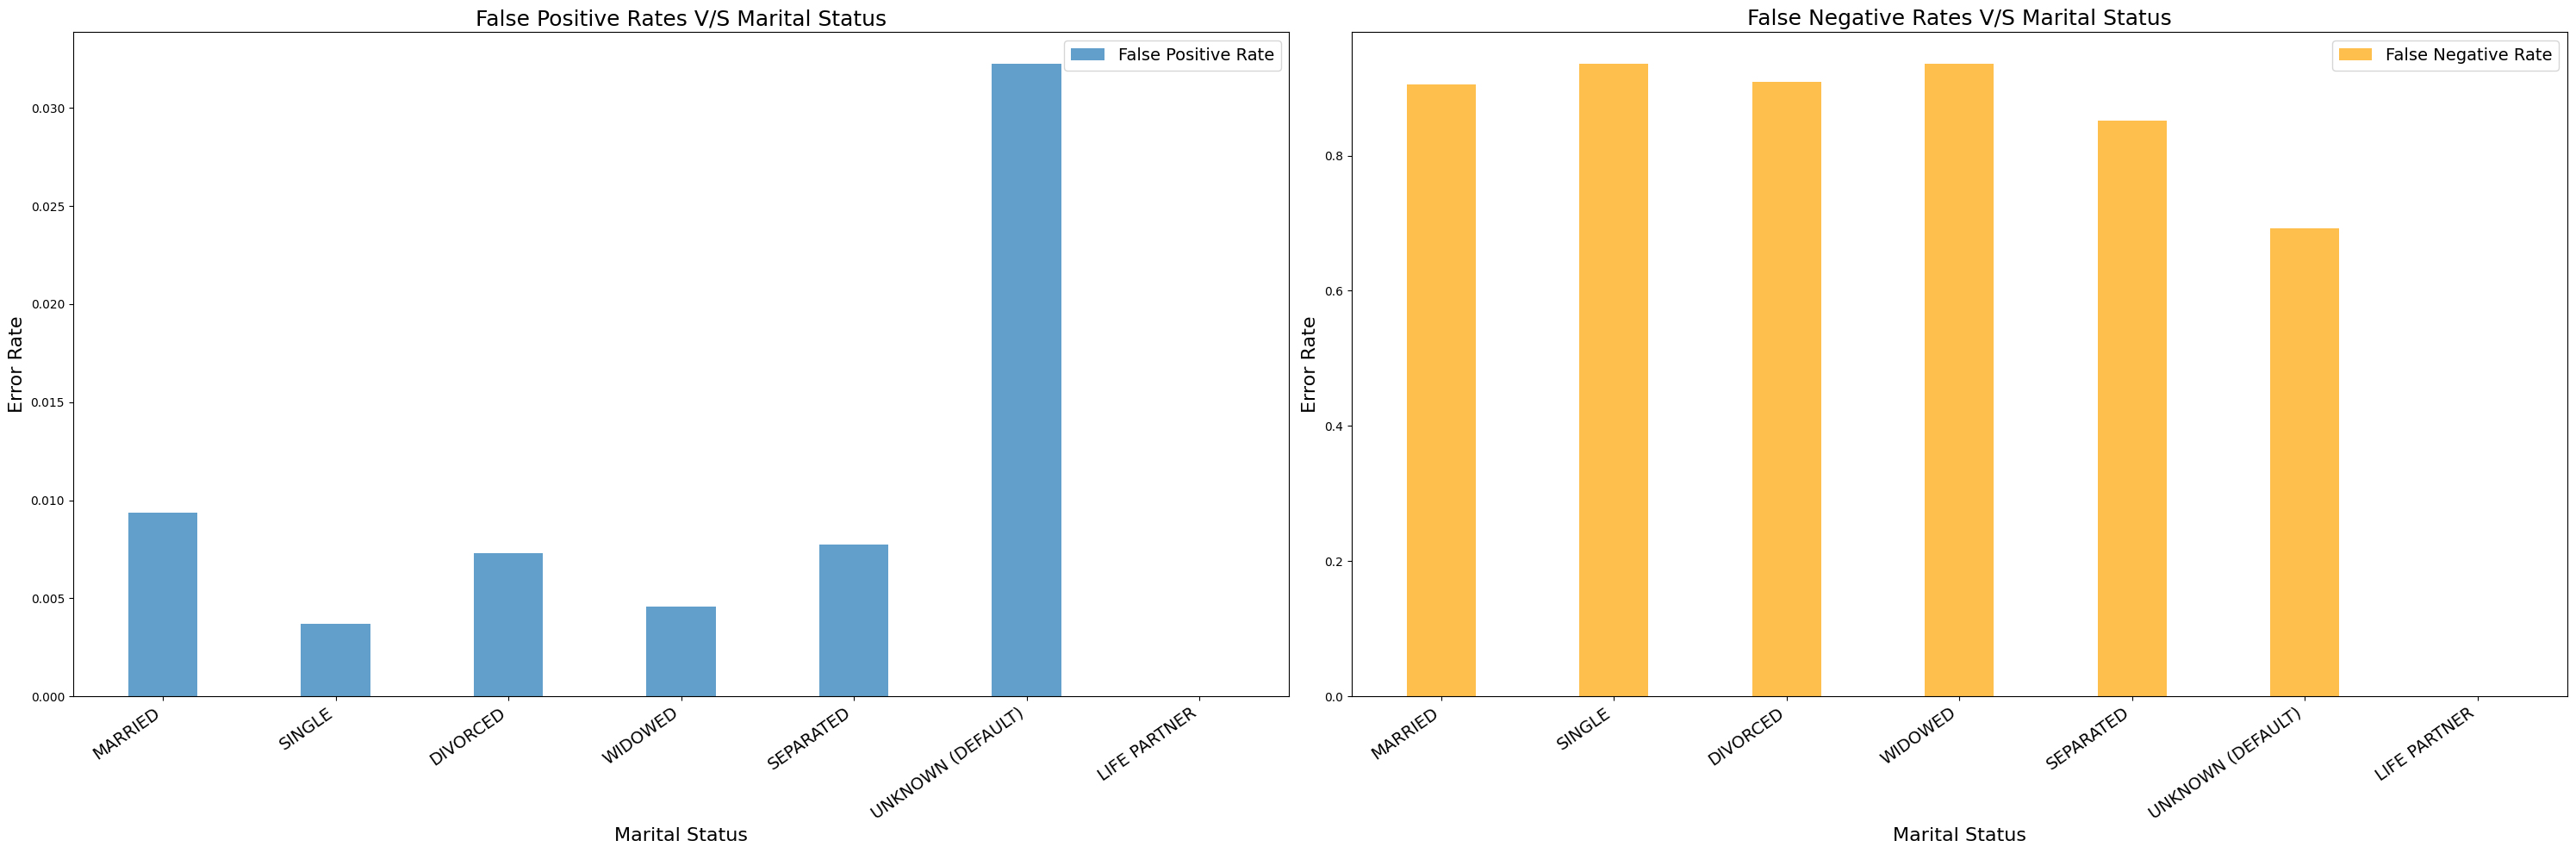

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10))  # Increased width and height

# False Positive Rate plot
axes[0].bar(marital_bias_df_cb["Marital Status"], marital_bias_df_cb["False Positive Rate"], label="False Positive Rate", alpha=0.7, width=0.4)
axes[0].set_xlabel("Marital Status", fontsize=16)
axes[0].set_ylabel("Error Rate", fontsize=16)
axes[0].set_title("False Positive Rates V/S Marital Status", fontsize=18)
axes[0].legend(fontsize=14)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].set_xticklabels(marital_bias_df_cb["Marital Status"], rotation=35, ha="right")  # Increased rotation

# False Negative Rate plot
axes[1].bar(marital_bias_df_cb["Marital Status"], marital_bias_df_cb["False Negative Rate"], label="False Negative Rate", alpha=0.7, color='orange', width=0.4)
axes[1].set_xlabel("Marital Status", fontsize=16)
axes[1].set_ylabel("Error Rate", fontsize=16)
axes[1].set_title("False Negative Rates V/S Marital Status", fontsize=18)
axes[1].legend(fontsize=14)
axes[1].tick_params(axis='x', labelsize=14)
axes[1].set_xticklabels(marital_bias_df_cb["Marital Status"], rotation=35, ha="right")  # Increased rotation

# Adjust spacing
plt.subplots_adjust(wspace=0.5, bottom=0.35)  # Increased space between subplots and bottom margin
plt.tight_layout()
plt.show()

In [ ]:
y_true = ehr_data['HOSPITAL_EXPIRE_FLAG'].values  # Actual hospital outcome
y_pred = ehr_data['predictions'].values            # Predicted outcomes

# List of sensitive features to evaluate
sensitive_features_list = ['GENDER', 'ETHNICITY', 'RELIGION', 'MARITAL_STATUS']

# Loop through each sensitive feature and compute fairness metrics
for feature in sensitive_features_list:
    groups = ehr_data[feature].values
    dem_parity = demographic_parity_difference(y_true=y_true, y_pred=y_pred, sensitive_features=groups)
    eq_odds = equalized_odds_difference(y_true=y_true, y_pred=y_pred, sensitive_features=groups)

    print(f"--- {feature} ---")
    print(f"Demographic Parity Difference: {dem_parity:.4f}")
    print(f"Equalized Odds Difference: {eq_odds:.4f}\n")

--- GENDER ---
Demographic Parity Difference: 0.0004
Equalized Odds Difference: 0.0087

--- ETHNICITY ---
Demographic Parity Difference: 0.1667
Equalized Odds Difference: 0.5000

--- RELIGION ---
Demographic Parity Difference: 0.0518
Equalized Odds Difference: 0.2000

--- MARITAL_STATUS ---
Demographic Parity Difference: 0.0843
Equalized Odds Difference: 0.3077

